# 載入所需函式庫

In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
import tensorflow as tf
import random as rn
import cv2                   
from tqdm import tqdm
import os                   
from random import shuffle  
from zipfile import ZipFile
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score,precision_score,recall_score,confusion_matrix,roc_curve,roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder
from keras.preprocessing.image import ImageDataGenerator
from keras import backend as K
from keras.models import Sequential
from keras.layers import Dense
from tensorflow.python.keras import optimizers
from tensorflow.keras import optimizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.optimizers import Adagrad
from tensorflow.keras.optimizers import Adadelta
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.utils import to_categorical
from keras.layers import Dropout, Flatten,Activation
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization

%matplotlib inline  
style.use('fivethirtyeight')
sns.set(style='whitegrid',color_codes=True)
X=[]
Z=[]

# 設置資料路徑

In [24]:
from google.colab import drive
drive.mount('/content/drive')

IMG_SIZE=150
FLOWER_DAISY_DIR='/content/drive/MyDrive/training_data/flowers/daisy'
FLOWER_SUNFLOWER_DIR='/content/drive/MyDrive/training_data/flowers/sunflower'
FLOWER_TULIP_DIR='/content/drive/MyDrive/training_data/flowers/tulip'
FLOWER_DANDI_DIR='/content/drive/MyDrive/training_data/flowers/dandelion'
FLOWER_ROSE_DIR='/content/drive/MyDrive/training_data/flowers/rose'


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# 自定義函式

In [25]:
def label_assign(img,flower_type):
    return flower_type

In [26]:
def training_data_prepare(flower_type,DIR):
    for img in tqdm(os.listdir(DIR)):
        label=label_assign(img,flower_type)
        path = os.path.join(DIR,img)
        img = cv2.imread(path,cv2.IMREAD_COLOR)
        img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))
        
        X.append(np.array(img))
        Z.append(str(label))

#製作訓練資料

In [27]:
training_data_prepare('Daisy',FLOWER_DAISY_DIR)

100%|██████████| 764/764 [00:06<00:00, 119.53it/s]


In [28]:
training_data_prepare('Sunflower',FLOWER_SUNFLOWER_DIR)

100%|██████████| 716/716 [00:06<00:00, 106.04it/s]


In [29]:
training_data_prepare('Tulip',FLOWER_TULIP_DIR)

100%|██████████| 984/984 [00:09<00:00, 99.64it/s] 


In [30]:
training_data_prepare('Dandelion',FLOWER_DANDI_DIR)

100%|██████████| 1052/1052 [00:08<00:00, 120.87it/s]


In [31]:
training_data_prepare('Rose',FLOWER_ROSE_DIR)

100%|██████████| 784/784 [00:06<00:00, 117.49it/s]


In [32]:
le=LabelEncoder()
Y=le.fit_transform(Z)
Y=to_categorical(Y,5)
X=np.array(X)
X=X/255

# 將資料分為Training set和Validation set兩組

In [33]:
x_train,x_test,y_train,y_test=train_test_split(X,Y,test_size=0.25,random_state=42)

In [34]:
np.random.seed(42)
rn.seed(42)
tf.random.set_seed(42)

# 建立、訓練模型&對測試集做預測


In [35]:
#建立CNN
model = Sequential()
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same',activation ='relu', input_shape = (150,150,3)))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same',activation ='relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
 
model.add(Conv2D(filters =96, kernel_size = (3,3),padding = 'Same',activation ='relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

model.add(Conv2D(filters = 96, kernel_size = (3,3),padding = 'Same',activation ='relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dense(5, activation = "softmax"))
batch_size=128
epochs=50

In [36]:
#在梯度下降法的學習率衰減，採用ReduceLROnPlateau(如果模型訓練n次之後沒有變得更好，就做一次學習率衰減)

from keras.callbacks import ReduceLROnPlateau
red_lr= ReduceLROnPlateau(monitor='val_acc',patience=3,verbose=1,factor=0.1)

In [37]:
#利用Data Augmentation方法增加訓練資料數量，避免Overfitting

datagen = ImageDataGenerator(
        featurewise_center=False, 
        samplewise_center=False, 
        featurewise_std_normalization=False, 
        samplewise_std_normalization=False, 
        zca_whitening=False,  # 白化
        rotation_range=10,  # 旋轉
        zoom_range = 0.1, # 放大
        width_shift_range=0.2,  # 水平移動
        height_shift_range=0.2,  # 垂直移動
        horizontal_flip=True,  # 水平翻轉
        vertical_flip=False)  # 垂直翻轉
datagen.fit(x_train)

In [38]:
#編譯Keras模型

model.compile(optimizer=Adam(lr=0.001),loss='categorical_crossentropy',metrics=['accuracy'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [39]:
#訓練模型&對測試集做預測

History = model.fit_generator(datagen.flow(x_train,y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (x_test,y_test),
                              verbose = 1, steps_per_epoch=x_train.shape[0] // batch_size)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  """


Epoch 1/50
25/25 [==============================] - 20s 748ms/step - loss: 1.5097 - accuracy: 0.3113 - val_loss: 1.2002 - val_accuracy: 0.4940
Epoch 2/50
25/25 [==============================] - 18s 718ms/step - loss: 1.2202 - accuracy: 0.4785 - val_loss: 1.0719 - val_accuracy: 0.5749
Epoch 3/50
25/25 [==============================] - 19s 738ms/step - loss: 1.1201 - accuracy: 0.5402 - val_loss: 1.0623 - val_accuracy: 0.5860
Epoch 4/50
25/25 [==============================] - 18s 717ms/step - loss: 1.0463 - accuracy: 0.5809 - val_loss: 0.9380 - val_accuracy: 0.6335
Epoch 5/50
25/25 [==============================] - 18s 721ms/step - loss: 0.9943 - accuracy: 0.6116 - val_loss: 0.9409 - val_accuracy: 0.6288
Epoch 6/50
25/25 [==============================] - 18s 762ms/step - loss: 0.9446 - accuracy: 0.6229 - val_loss: 0.8974 - val_accuracy: 0.6698
Epoch 7/50
25/25 [==============================] - 18s 731ms/step - loss: 0.9162 - accuracy: 0.6490 - val_loss: 0.8637 - val_accuracy: 0.6586

# 評估模型的好壞

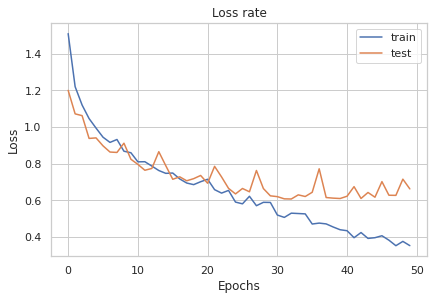

In [40]:
plt.plot(History.history['loss'])
plt.plot(History.history['val_loss'])
plt.title('Loss rate')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()

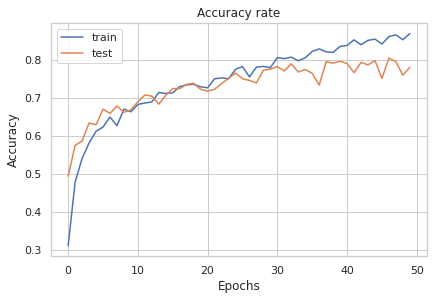

In [41]:
plt.plot(History.history['accuracy'])
plt.plot(History.history['val_accuracy'])
plt.title('Accuracy rate')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()

# 印出測試集中各10筆預測正確與錯誤的資料

In [42]:
#對測試集做預測
pred=model.predict(x_test)
pred_digits=np.argmax(pred,axis=1)
y_test_digits=np.argmax(y_test,axis=1)

#儲存各10筆預測正確與錯誤的資料
true_pred=[]
false_pred=[]
for i in range(len(y_test)):
    if(np.argmax(y_test[i])==pred_digits[i]):
        true_pred.append(i)
    if(len(true_pred)==10):
        break

for i in range(len(y_test)):
    if(not np.argmax(y_test[i])==pred_digits[i]):
        false_pred.append(i)
    if(len(false_pred)==10):
        break

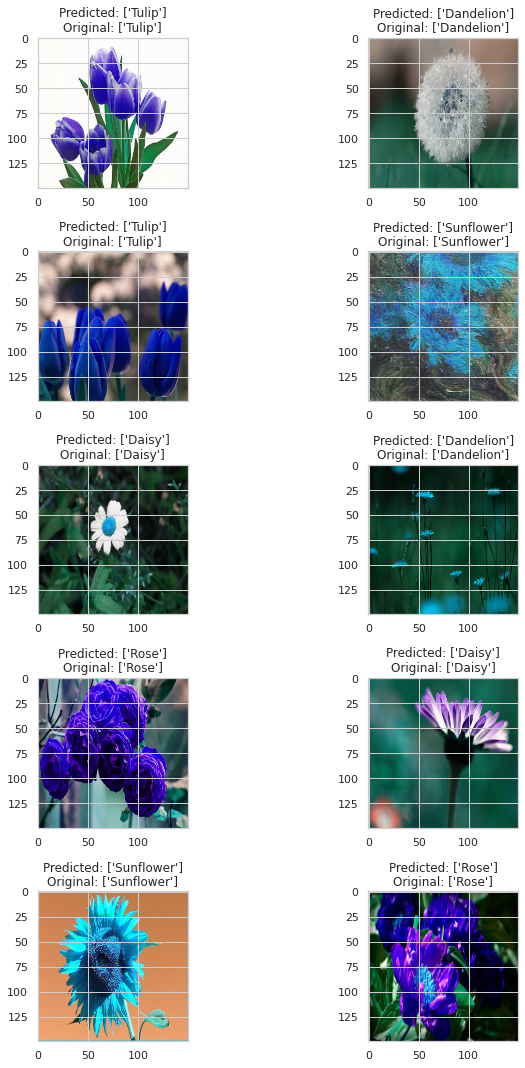

In [43]:
#印出10筆正確預測的資料

n=0
fig,ax=plt.subplots(5,2)
fig.set_size_inches(15,15)
for i in range (5):
    for j in range (2):
        ax[i,j].imshow(x_test[true_pred[n]])
        ax[i,j].set_title("Predicted: "+str(le.inverse_transform([pred_digits[true_pred[n]]]))+"\n"+"Original: "+str(le.inverse_transform([y_test_digits[true_pred[n]]])))
        plt.tight_layout()
        n+=1

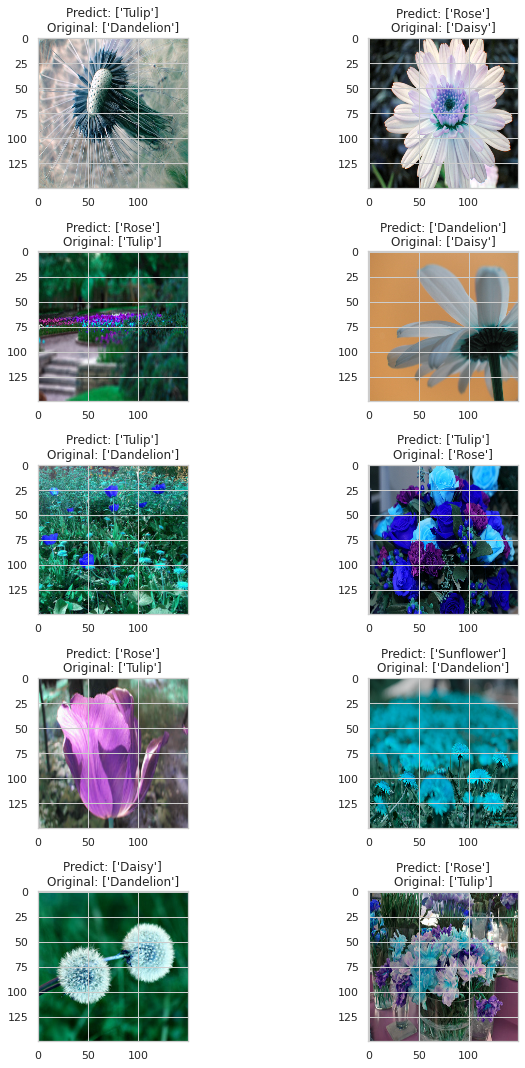

In [45]:
#印出10筆錯誤預測的資料

n=0
fig,ax=plt.subplots(5,2)
fig.set_size_inches(15,15)
for i in range (5):
    for j in range (2):
        ax[i,j].imshow(x_test[false_pred[n]])
        ax[i,j].set_title("Predict: "+str(le.inverse_transform([pred_digits[false_pred[n]]]))+"\n"+"Original: "+str(le.inverse_transform([y_test_digits[false_pred[n]]])))
        plt.tight_layout()
        n+=1